Train the U-Net model

These codes are modified based on Abhinav Sagar, Nucleus Segmentation using U-Net, https://towardsdatascience.com/nucleus-segmentation-using-u-net-eceb14a9ced4

In [1]:
#import useful libraries
import os
import sys
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from skimage import io
import tensorflow as tf
from functions import *


In [2]:
BATCH_SIZE = 10 # the higher the better
IMG_WIDTH = 128 # for faster computing on kaggle
IMG_HEIGHT = 128 # for faster computing on kaggle
IMG_CHANNELS = 3 
TRAIN_PATH = './stage1_train/'
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

#load all the file name into training and testing directory
train_ids = next(os.walk(TRAIN_PATH))[1]

np.random.seed(10)#the 10th seed


In [3]:
# build X and Y train set
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()#output on the same line with time interval
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):#why _
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    #make tif from 256*256 to 128*128 to increase computational speed
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:#what is [2]
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask# what do this mask fun do?

Getting and resizing train images and masks ... 


C:\Users\ZKR\AppData\Local\Temp\ipykernel_5328\2171445504.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
  0%|          | 0/100 [00:00<?, ?it/s]C:\Users\ZKR\AppData\Local\Temp\ipykernel_5328\2171445504.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.ze

In [4]:
x,y,x_val,y_val=data_aug(X_train,Y_train)

train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [5]:

model = trainU_net(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])#tf.keras.metrics.MeanIoU(num_classes=2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [6]:
# fit the model
#Stop training when a monitored metric has stopped improving.
earlystopper = EarlyStopping(patience=3, verbose=1)
# save a model or weights (in a checkpoint file) at some interval, 
#so the model or weights can be loaded later to continue the training from the state saved.
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
#default batch size is 32. We use fit_generator(), since there are data argumentation
results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=100,
                              epochs=5, callbacks=[earlystopper, checkpointer])
results.history

c:\Users\ZKR\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
100/100 [==============================] - 59s 555ms/step - loss: 0.3235 - accuracy: 0.8215 - val_loss: 0.1076 - val_accuracy: 0.9579

Epoch 00001: val_loss improved from inf to 0.10764, saving model to model.h5
Epoch 2/5
100/100 [==============================] - 55s 547ms/step - loss: 0.1682 - accuracy: 0.8899 - val_loss: 0.0921 - val_accuracy: 0.9645

Epoch 00002: val_loss improved from 0.10764 to 0.09206, saving model to model.h5
Epoch 3/5
100/100 [==============================] - 56s 563ms/step - loss: 0.1479 - accuracy: 0.8980 - val_loss: 0.0790 - val_accuracy: 0.9702

Epoch 00003: val_loss improved from 0.09206 to 0.07899, saving model to model.h5
Epoch 4/5
100/100 [==============================] - 55s 550ms/step - loss: 0.1449 - accuracy: 0.8992 - val_loss: 0.0751 - val_accuracy: 0.9708

Epoch 00004: val_loss improved from 0.07899 to 0.07507, saving model to model.h5
Epoch 5/5
100/100 [==============================] - 55s 550ms/step - loss: 0.1232 - accuracy: 0.906

{'loss': [0.32353994250297546,
  0.16815313696861267,
  0.1478898674249649,
  0.14487506449222565,
  0.12320280820131302],
 'accuracy': [0.8214518427848816,
  0.8899240493774414,
  0.8979663848876953,
  0.8992491960525513,
  0.9059960842132568],
 'val_loss': [0.10764157027006149,
  0.0920599102973938,
  0.0789913609623909,
  0.0750730112195015,
  0.07590647041797638],
 'val_accuracy': [0.9579101800918579,
  0.9644775390625,
  0.9702209234237671,
  0.970843493938446,
  0.970904529094696]}

In [7]:
#save your loss data
mse = np.array((results.history['loss']))
val_mse=np.array((results.history['val_loss']))
#np.save('loss.npy', mse)
#np.save('val_loss.npy', val_mse)
acc = np.array((results.history['accuracy']))
val_acc=np.array((results.history['val_accuracy']))
#np.save('acc.npy', acc)
#np.save('val_acc.npy', val_acc)

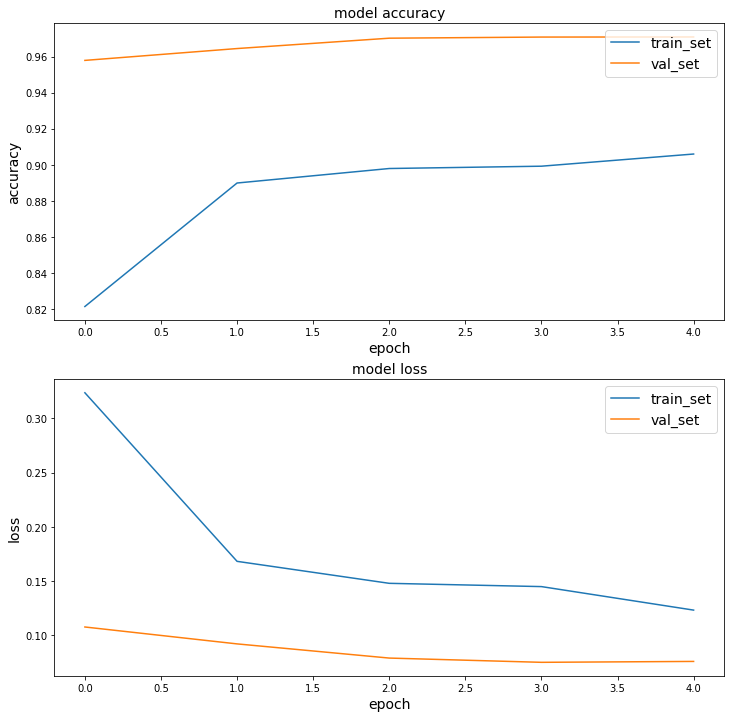

<Figure size 432x288 with 0 Axes>

In [8]:
# summarize history and plot the relevant data
plt.figure(figsize=(12,12))
plt.subplot(211)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy',fontsize=14)
plt.ylabel('accuracy',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train_set', 'val_set'], loc='upper right',fontsize=14)
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss',fontsize=14)
plt.ylabel('loss',fontsize=14)
plt.xlabel('epoch',fontsize=14)
plt.legend(['train_set', 'val_set'], loc='upper right',fontsize=14)
plt.show()
plt.savefig('summary.png')
